In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display
from PIL import Image
import pathlib
import pickle
import json
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Do Not Load The Data Here

In [3]:
df = pd.read_pickle("/content/drive/MyDrive/APS360/Data/size800x600.pickle")

In [4]:
LABELS = {
    "red blood cell": 1, 
    "leukocyte": 1, 
    "gametocyte": 0, 
    "trophozoite": 0, 
    "schizont": 0, 
    "ring": 0, 
    "difficult": 0
}

In [5]:
try: df = df.drop(columns=["imgpath", "imgshape"])
except: pass
df.columns

Index(['image', 'objects'], dtype='object')

In [6]:
width = 800
height = 600

transform = transforms.Compose([
    transforms.ToTensor(), 
])

boxes = []
labels = []
for index, (image, objects) in df.iterrows(): 
    df["image"][index] = transform(image)
    boxes.append([])
    labels.append([])
    for obj in objects: 
        box = obj["bounding_box"]
        box[0] *= width
        box[1] *= height
        box[2] *= width
        box[3] *= height
        boxes[index].append(box)
        label = LABELS[obj["category"]]
        labels[index].append(label)
    boxes[index] = torch.tensor(boxes[index], dtype=torch.float16)
    labels[index] = torch.tensor(labels[index], dtype=torch.int8)

df["boxes"] = boxes
df["labels"] = labels
del boxes, labels
df = df.drop(columns=["objects"])
df.columns

Index(['image', 'boxes', 'labels'], dtype='object')

In [7]:
class MalariaDataset(Dataset): 
    def __init__(self, df, transform=None): 
        self.df = df
        self.transform = transform

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, index): 
        images, boxes, labels = self.df[index]
        if self.transform: 
            images = self.transform(images)
        return images, (boxes, labels)

def get_loader(df, batch_size=32, transform=None): 
    dataset = MalariaDataset(df, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [8]:
num_samples = len(df)
a = int(num_samples * 0.8)
b = int(num_samples * 0.9)

np_df = df.to_numpy()
del df
np.random.seed(1000)
np.random.shuffle(np_df)

df_trn = np_df[:a]
df_val = np_df[a:b]
df_tst = np_df[b:]
del np_df

In [9]:
data_dir = pathlib.Path("/content/drive/MyDrive/APS360/Data/Detection")
try: os.mkdir(data_dir)
except: assert os.path.isdir(data_dir)

In [10]:
trn_loader = get_loader(df_trn)
val_loader = get_loader(df_val)
tst_loader = get_loader(df_tst)
del df_trn, df_val, df_tst

In [ ]:
with open(data_dir / "trn_loader.pkl", "wb") as f: 
    pickle.dump(trn_loader, f)

In [ ]:
with open(data_dir / "val_loader.pkl", "wb") as f: 
    pickle.dump(val_loader, f)

In [ ]:
with open(data_dir / "tst_loader.pkl", "wb") as f: 
    pickle.dump(tst_loader, f)

### Load The Data Here

In [ ]:
trn_loader = pickle.load(open(data_dir / "trn_loader.pkl", "rb"))
val_loader = pickle.load(open(data_dir / "val_loader.pkl", "rb"))
tst_loader = pickle.load(open(data_dir / "tst_loader.pkl", "rb"))

## Helper Functions

In [18]:
def show_sample(sample):
    (image, boxes, labels) = sample
    fig, axes = plt.subplots(1)
    axes.imshow(image.numpy().transpose(1, 2, 0))
    for box, label in zip(boxes, labels):
        color = "red" if label == 0 else "green"
        width, height = box[2] - box[0], box[3] - box[1]
        bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
        axes.add_patch(bounding_box)

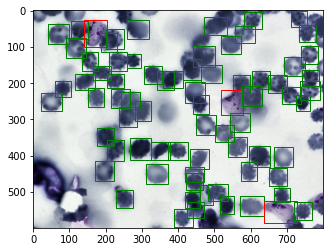

In [19]:
show_sample(df.iloc[0].values)

In [ ]:
for images, boxes, labels in val_loader: 
    image = images[0]
    targets = boxes[0]
    label = labels[0]
    break


In [ ]:
model1 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=3, pretrained_backbone=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# in_features = model1.roi_heads.box_predictor.cls_score.in_features
# model1.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)

# Training

In [ ]:
def train(model, imgsize, batch_size=32, learning_rate=0.001, num_epochs = 10):    

    model.train()
    torch.manual_seed(1000)

    train_dataset = TrainDataset(df_trn, imgsize)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x:x)
    val_dataset = TrainDataset(df_val, imgsize)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x:x)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=learning_rate)

    model_path = f"/content/drive/MyDrive/APS360/rcnn/models/rcnn_bs{batch_size}_lr{learning_rate}"

    train_loss = np.zeros(num_epochs)
    val_error = np.zeros(num_epochs)
    n = len(train_loader)

    for epoch in range(num_epochs):
        epoch_loss = 0 
        for i, (images, targets) in enumerate(train_loader): 
            
            loss_dict = model(images, targets) # in train mode
            loss = sum(x for x in loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
  
        train_loss[epoch] = epoch_loss / batch_size
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.4f}")

        torch.save(model.state_dict(), model_path+f"epoch_{epoch}")

    return model_path

In [ ]:
train(model, (400,300))